In [1]:
import numpy as np
import torch
import pandas as pd
import odbo
import os
import gc

In [97]:
random_seed = 7
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/GB1_2014_536085.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['score'])
Y_test = 2**Y_test
del data_test
if os.path.isfile('sele_indices_GB1_2014.npy') == True:
    sele_indices = np.load('sele_indices_GB1_2014.npy')
    shuffle_order = np.load('shuffle_order_GB1_2014.npy')
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)    
else:
    shuffle_order = np.arange(len(Y_test))
    np.random.shuffle(shuffle_order[1:])
    np.save('shuffle_order_GB1_2014.npy', shuffle_order)
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)
    sele_indices = odbo.initialization.initial_design(name, least_occurance=np.ones(55),allow_abundance=False,update_method='correlate',verbose=True)
    np.save('sele_indices_GB1_2014.npy', sele_indices)
name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
ids_keep = np.delete(range(len(Y_test)), sele_indices)
name, Y_test = name[ids_keep, :], Y_test[ids_keep]
print('Selected initial experiments no. is ', len(Y_train))
print('Select max Y: ', Y_train.max(), 'True max Y:', Y_test.max())


Selected initial experiments no. is  136
Select max Y:  3.401744910907966 True max Y: 5.773617201642364


In [98]:
feature_model = odbo.featurization.FewFeatureTransform(raw_vars=name_sele, Y=Y_train, method='Avg', mode='hybrid')
X_test = feature_model.transform(name)
X_train = feature_model.transform(name_sele)

1.0
[22:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Correct ratio: 76.516%
FN ratio: 8.401%
FP ratio: 15.083%


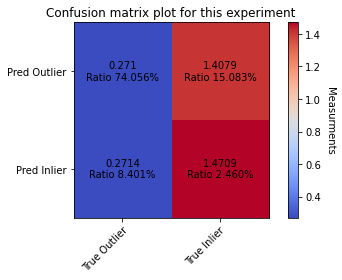

In [99]:
# Find the adaptive search space model
threshold = Y_train[np.argsort(Y_train)[int(0.9*len(Y_train))]]
print(threshold)
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error', random_state = random_seed)
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test))) 

## ODBO, BO

In [ ]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print("Prescreening size: ", len(sele_id_test))

## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 100
batch_size = 1
gp_method='robust_regression'
failure_count = 0
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), "Test max: ", Y_test_sele.max().detach().numpy())
    top_ids = np.argsort(Y_train_sele.numpy().ravel())[-40-l:]
    sele_feat = []
    for i in range(X_train_sele.shape[1]):
        if (X_train_sele[top_ids,i]-X_train_sele[0,i]).any() !=0:
            sele_feat.append(i)
    X_sele = X_train_sele[:,sele_feat]
    X_test_sele=X_test_sele[:, sele_feat]
    X_test_sele = torch.cat([X_test_sele, X_test_sele[:, [1,0,3,2]]])
    X_sele = torch.cat([X_sele[top_ids, :], X_sele[top_ids, :][:, [1,0,3,2]]])
    Y_sele = torch.cat([Y_train_sele[top_ids], Y_train_sele[top_ids]])
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_sele, Y=Y_sele, X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    next_exp_id = np.mod(next_exp_id, len(Y_test_sele))
    Y_train_sele = torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(Y_test_sele.shape[0]), next_exp_id))
    Y_test_sele = Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), ''.join(name_sele_temp[-1, :]))

    if Y_train_sele[-batch_size:].detach().numpy().max() > Y_train_sele[:-batch_size].max():
        failure_count = 0
        feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
    else:
        failure_count = failure_count + 1
        if failure_count >= 3:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
        else:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')

    X_test_sele= torch.tensor(feature_model1.transform(search_name_sele))
    X_train_sele = torch.tensor(feature_model1.transform(name_sele_temp))
    l = l + 1
    
np.save('results/GB1_2014/GB1_2014_ODBO_BO_RobustGP_batch1_{}.npy'.format(random_seed), np.log2(Y_train_sele))


## ODBO, TuRBO

In [ ]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print("Prescreening size: ", len(sele_id_test))
l, search_iter = 0, 100
gp_method='gp_regression'
tr_length = [6.4]
batch_size = 1
failure_count = 0
state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 20)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, "Test max: ", Y_test_sele.max().detach().numpy(),  ''.join(search_name_sele[torch.argmax(Y_test_sele), :]))
    top_ids = np.argsort(Y_train_sele.numpy().ravel())[-40-l:]
    sele_feat = []
    for i in range(X_train_sele.shape[1]):
        if (X_train_sele[top_ids,i]-X_train_sele[0,i]).any() !=0:
            sele_feat.append(i)
    X_sele = X_train_sele[:,sele_feat]
    X_test_sele=X_test_sele[:, sele_feat]
    X_test_sele = torch.cat([X_test_sele, X_test_sele[:, [1,0,3,2]]])
    X_sele = torch.cat([X_sele[top_ids, :], X_sele[top_ids, :][:, [1,0,3,2]]])
    Y_sele = torch.cat([Y_train_sele[top_ids], Y_train_sele[top_ids]])
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_sele, Y=Y_sele, X_pending=X_test_sele, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    raw_next_exp_id = raw_next_exp_id % len(Y_test_sele)
    next_exp_id = []  
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
    Y_train_sele = torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(Y_test_sele.shape[0]), next_exp_id))
    Y_test_sele = Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), ''.join(name_sele_temp[-1, :]))
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    if Y_train_sele[-batch_size:].detach().numpy().max() > Y_train_sele[:-batch_size].max():
        failure_count = 0
        feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')
    else:
        failure_count = failure_count + 1
        if failure_count >= 3:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
        else:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')
    X_test_sele= torch.tensor(feature_model1.transform(search_name_sele))
    X_train_sele = torch.tensor(feature_model1.transform(name_sele_temp))
    l = l + 1
np.save('results/GB1_2014/GB1_2014_ODBO_TuRBO_GP_batch1_{}.npy'.format(random_seed), np.log2(Y_train_sele))



Prescreening size:  58211
Iter:  0 Current Max:  3.401744910907966 TR length:  [6.4] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[1.57808948]] QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDGYTKTFTVTE
Iter:  1 Current Max:  3.401744910907966 TR length:  [6.4] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[0.83391609]] QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVGGEWTYGDATKTFTVTE
Iter:  2 Current Max:  3.401744910907966 TR length:  [6.4] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[0.56403359]] QYKLILNGKTLKGETTTEYVGAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Iter:  3 Current Max:  3.401744910907966 TR length:  [6.4] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[3.59885487]] AYKLILNGKTLKGETTTEAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Iter:  4 Current Max:  3.598854871

Newly added value:  [[1.96187657]] QYKLILNGKTLKGETTTEAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTGTE
Iter:  35 Current Max:  3.5988548711069273 TR length:  [3.2] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[1.35552661]] QYKLYLNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDITKTFTVTE
Iter:  36 Current Max:  3.5988548711069273 TR length:  [3.2] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[3.76363284]] QYKLILNGKTLKGETTTEAVDAYTAEKVFKQYANDNGVDGEWTYDDITKTFTVTE
Iter:  37 Current Max:  3.763632836566744 TR length:  [3.2] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[0.2272628]] QYKLILNGKTLKGETTTEAVDIITAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Iter:  38 Current Max:  3.763632836566744 TR length:  [3.2] Test max:  5.773617201642364 QYKLILNGKTLKGETTTQAVDAYTAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Newly added value:  [[1.38657807]] QYKLILNGKTLKGETTTEAV

## Random selection

In [29]:
sele_Y = list(np.random.choice(Y_test, 100, replace = False))
Y_train_sele = list(Y_train.copy())
Y_train_sele.extend(sele_Y)
print('Max Y', max(sele_Y))
np.save('results/GB1_2014/GB1_2014_random_{}.npy'.format(random_seed), np.log2(Y_train_sele))

Max Y 3.0781958899755852
